# Introduction

Do not spend too much time trying to get very tiny metrics improvement. Once you have a model with a correct predictive power, you should better spend time explaining your data cleaning & preparation pipeline as well as explanations & visualizations of the results.

The goal is to see your fit with our company culture & engineering needs, spending 50h on an over-complicated approach will not give you bonus points compared to a simple, yet effective, to-the-point solution.

## About the data

The dataset you will be working with is called Emo-DB and can be found [here](http://emodb.bilderbar.info/index-1280.html).

It is a database containing samples of emotional speech in German. It contains samples labeled with one of 7 different emotions: Anger, Boredom, Disgust, Fear, Happiness, Sadness and Neutral. 

Please download the full database and refer to the documentation to understand how the samples are labeled (see "Additional information")
   
The goal of this project is to develop a model which is able to **classify samples of emotional speech**. Feel free to use any available library you would need, but beware of re-using someone else's code without mentionning it!

## Deliverable

The end-goal is to deliver us a zip file containing:
* This report filled with your approach, in the form of an **iPython Notebook**.
* A **5-10 slides PDF file**, containing a technical presentation covering the important aspects of your work
* A Dockerfile which defines a container for the project. The container should handle everything (download the data, run the code, etc...). When running the container it should expose the jupyter notebook on one port and expose a Flask API on another one. The Flask app contains two endpoints:
  - One for training the model
  - One for querying the last trained model with an audio file of our choice in the dataset
* A README.md which should contain the commands to build and run the docker container, as well as how to perform the queries to the API. 
* Any necessary .py, .sh or other files needed to run your code.

# Notes

Parts of the code are inspired from the following sources:

- https://github.com/marcogdepinto/emotion-classification-from-audio-files
- https://github.com/seth814/Audio-Classification
- https://github.com/jameslyons/python_speech_features
- https://github.com/ajhalthor/audio-classifier-convNet

# Libraries Loading

In [1]:
import librosa
from librosa import display
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank

In [2]:
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint

#import tensorflow as tf
import keras
from keras.preprocessing import sequence
from keras.layers import Embedding
from keras.utils import to_categorical
from keras.layers import Input, Activation
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, AveragePooling1D
from keras.models import Model
from keras.optimizers import Adadelta
from keras import regularizers

Using TensorFlow backend.


In [3]:
import pickle
import sys

In [4]:
sys.path.append('../scripts')
from cfg import Config 
from pickledataset import PickleDataset

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [6]:
import IPython.display as ipd

# Data Preparation & Cleaning

In [7]:
pwd

'/home/jupyter/tutorials/tf2_course/visium/notebooks'

### Data example

Lets look at a single audio file to see how it is structured.

In [8]:
signal, _ = librosa.load('../data/wav/03a01Fa.wav')
sr, _ = wavfile.read('../data/wav/03a01Fa.wav')

In [9]:
print(signal.shape)
print(sr)

(41857,)
16000


We see that the audio file has one channel (mono) and it has a sampling rate frequency of 16 kHz.

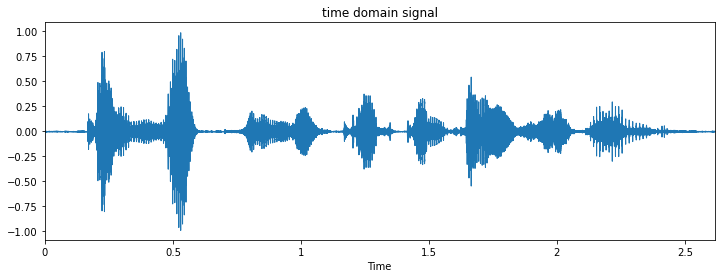

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
librosa.display.waveplot(signal, sr=sr)
plt.title('time domain signal')
plt.show()

Usually, one analyzes time-series data in the frequency domain and not the time domain. To switch from time domain to frequency domain, we can compute the FFT of the data to obtain a periodogram (the power spectral density estimate) which will highlight the important frequencies.

In [11]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

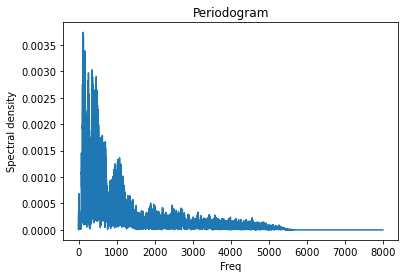

In [12]:
fft = calc_fft(signal, sr)
data = list(fft)
Y, freq = data[0], data[1]

fig, ax = plt.subplots()
plt.plot(freq, Y)
plt.title('Periodogram')
plt.ylabel('Spectral density')
plt.xlabel('Freq')
plt.show()

The periodogram goes to 8 kHz, but audio is typically recorded at 44.1 kHz. The Nyquist freq is 44.1 / 2 = 22.5 kHz and is the highest frequency from the environment we can represent. We usually downsample audio to 16 kHz (most information contained in the audio is below 8 kHz which would be the Nyquist freq).

We take the Short Time Fourier Transform where we use small intervals of audio (assume stationarity), take a window size of 25 ms (standard practice), slide the window forward 10 ms, use a Hanning window for the FFT computation to avoid spectral leakage. We then obtain 2d images with "signatures" for each sound.  

https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

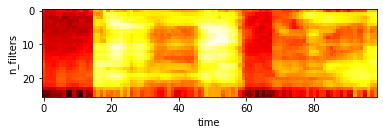

In [13]:
bank = logfbank(signal[:sr], sr, nfilt=26, nfft=400).T

fig, ax = plt.subplots()
plt.imshow(bank,cmap='hot', interpolation='nearest')
plt.ylabel('n_filters')
plt.xlabel('time')
plt.show()

As humans, it's easy to tell apart low freqs (10 vs 100 Hz), but difficult for high freqs (15'000 vs 15'100 Hz). In order to differentiate higher freqs, we scale freqs with log to obtain the Mel scale. We care about differences in small freqs not differences in large freqs. To do so, we use a filter bank (26 triangular filters to bin energies) and build input features based on the power spectral density (image of size 26x100 if taking 1s of data).

http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/


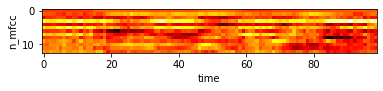

In [14]:
mfccs = mfcc(signal[:sr], sr, numcep=13, nfilt=26, nfft=400).T

fig, ax = plt.subplots()
plt.imshow(mfccs, cmap='hot', interpolation='nearest')
plt.ylabel('n_mfcc')
plt.xlabel('time')
plt.show()

By taking the STFT, we have overlap in samples which leads to correlated samples. To decorrelate the samples, we perform a DCT on the filter bank energies and get 26x100 samples again. We usually take a fraction of the mfccs (eg. the first 13, or 40 mfccs since we are only interested in the low freqs).  

http://datagenetics.com/blog/november32012/index.html

Finally, we can train a model to classify audio samples based on their mfcc decomposition. One could imagine using a CNN model since the mffcs are 2-dimensional. However, as we will see, we can apply more traditional models as well.

### EDA

In [15]:
path = '../data/wav'
df = os.listdir(path)
print(df[:5])

['16b10Fb.wav', '16a01Tb.wav', '12b03Ta.wav', '11b09Wa.wav', '09a05Lc.wav']


We see that the audio files are structured as follows:

- the first two digits indicate the speaker id (eg. 16)
- the next three characters/digits indicate the spoken sentence (eg. b10)
- the next character indicates the true emotion (eg. F)
- the last character before the file extension indicates the version (eg. a)

In [16]:
speaker = [file[:2] for file in df]
text = [file[2:5] for file in df]
emotion = [file[5] for file in df]

print(np.unique(speaker), len(np.unique(speaker)))
print(np.unique(text), len(np.unique(text)))
print(np.unique(emotion), len(np.unique(emotion)))

['03' '08' '09' '10' '11' '12' '13' '14' '15' '16'] 10
['a01' 'a02' 'a04' 'a05' 'a07' 'b01' 'b02' 'b03' 'b09' 'b10'] 10
['A' 'E' 'F' 'L' 'N' 'T' 'W'] 7


- We see that there are 10 different speakers.
- There are 10 different spoken sentences.
- There are 7 different emotions (classes).

In [17]:
df = pd.DataFrame(df, columns=['filename'])
df['speaker'] = speaker
df['text'] = text
df['emotion'] = emotion
print(df)

        filename speaker text emotion
0    16b10Fb.wav      16  b10       F
1    16a01Tb.wav      16  a01       T
2    12b03Ta.wav      12  b03       T
3    11b09Wa.wav      11  b09       W
4    09a05Lc.wav      09  a05       L
..           ...     ...  ...     ...
530  15b02Nd.wav      15  b02       N
531  11b10Ld.wav      11  b10       L
532  16b03Ad.wav      16  b03       A
533  03a02Wb.wav      03  a02       W
534  14a01Na.wav      14  a01       N

[535 rows x 4 columns]


In [18]:
classes = np.unique(df.emotion)
num_classes = len(classes)
print(classes)
print(num_classes)

['A' 'E' 'F' 'L' 'N' 'T' 'W']
7


The classes are:
- A: Angst
- E: Ekel
- F: Freude
- L: Langeweile
- N: Neutral
- T: Trauer
- W: Wut (Ärger)

We compute the length of each file in seconds.

In [19]:
df.set_index(df.filename, inplace=True)
for file in df.index:
    rate, signal = wavfile.read(f'{path}/{file}')
    df.at[file, 'length'] = signal.shape[0] / rate

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
emotion_count_by_class = df.groupby('emotion')['filename'].count()

In [21]:
emotion_count_by_class_pct = emotion_count_by_class / emotion_count_by_class.sum()

In [22]:
emotion_count_by_class_pct

emotion
A    0.128972
E    0.085981
F    0.132710
L    0.151402
N    0.147664
T    0.115888
W    0.237383
Name: filename, dtype: float64

We see that the classes are not all equally balanced. There are slightly more 'W' than the rest (3x more 'W' than 'E'). Class balancing techniques may be considered in further analysis.

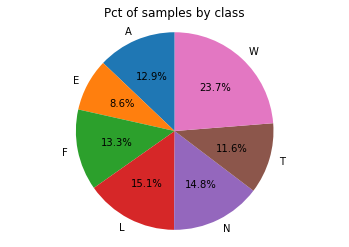

In [23]:
fig, ax = plt.subplots()
ax.set_title('Pct of samples by class')
ax.pie(emotion_count_by_class_pct, labels=emotion_count_by_class_pct.index, autopct='%1.1f%%',
      shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [24]:
avg_sample_length_by_class = df.groupby('emotion')['length'].mean()

In [25]:
avg_sample_length_by_class

emotion
A    2.233377
E    3.352834
F    2.543967
L    2.778977
N    2.359236
T    4.052895
W    2.640795
Name: length, dtype: float64

We see that the average length of samples by class is approximately the same. Class 'T' has some longer samples.

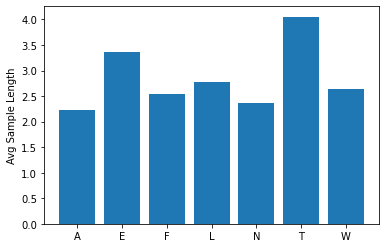

In [26]:
fig, ax = plt.subplots()
ax.bar(np.arange(num_classes), avg_sample_length_by_class)
ax.set_ylabel('Avg Sample Length')
ax.set_xticks(np.arange(num_classes))
ax.set_xticklabels(classes)
plt.show()

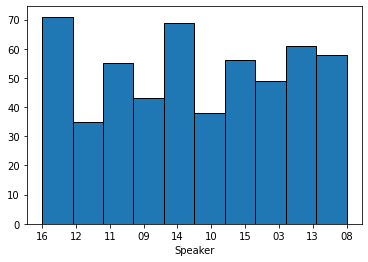

In [27]:
fig, ax1 = plt.subplots()
df['speaker'].hist(ax=ax1, bins=10, edgecolor='black')
ax1.grid(False)
ax1.set_xlabel('Speaker')
plt.show()

We see that all speakers roughly recorded the same amount of audio samples.

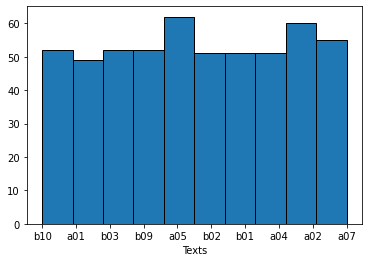

In [28]:
fig, ax1 = plt.subplots()
df['text'].hist(ax=ax1, bins=10, edgecolor='black')
ax1.grid(False)
ax1.set_xlabel('Texts')
plt.show()

We see that texts are uniformly distributed.

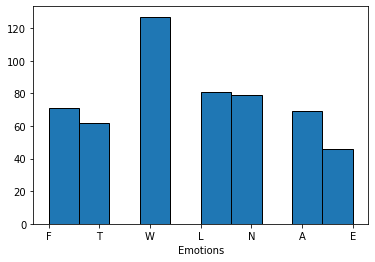

In [29]:
fig, ax1 = plt.subplots()
df['emotion'].hist(ax=ax1, bins=10, edgecolor='black')
ax1.grid(False)
ax1.set_xlabel('Emotions')
plt.show()

We see that class 'W' is a lot more present than the others. This might cause issues during modelling so it is good to keep in mind. One could consider undersampling class 'W' in the training set, or oversample the other classes.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:335: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


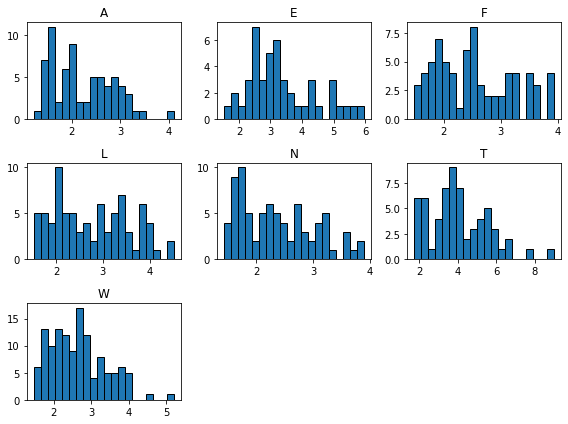

In [30]:
fig, ax1 = plt.subplots(figsize=(8, 6))
df['length'].hist(by=df['emotion'], xrot=0, ax=ax1, bins=20, edgecolor='black')
plt.tight_layout()
plt.show()

In [31]:
df.groupby('emotion')['length'].describe()

,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
A,69.0,2.233377,0.637358,1.225500,1.607938,2.081313,2.711750,4.101375
E,46.0,3.352834,1.073298,1.523813,2.552859,3.117188,3.943766,5.963813
F,71.0,2.543967,0.682695,1.481375,1.963625,2.463563,3.106813,3.930938
L,81.0,2.778977,0.804450,1.520063,2.074688,2.690562,3.398750,4.525812
N,79.0,2.359236,0.659165,1.430813,1.769750,2.235500,2.822000,3.899188
T,62.0,4.052895,1.532625,1.735688,3.076344,3.863375,5.102375,8.978250
W,127.0,2.640795,0.728803,1.465812,2.090094,2.609875,3.116937,5.213500


The last histogram plots and the table show that distribution of sample length grouped by emotion is roughly the same. Looking at the IQR, we see that most of the data is between 2 and 3 seconds, apart for samples with emotion 'E' and 'T'.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:335: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


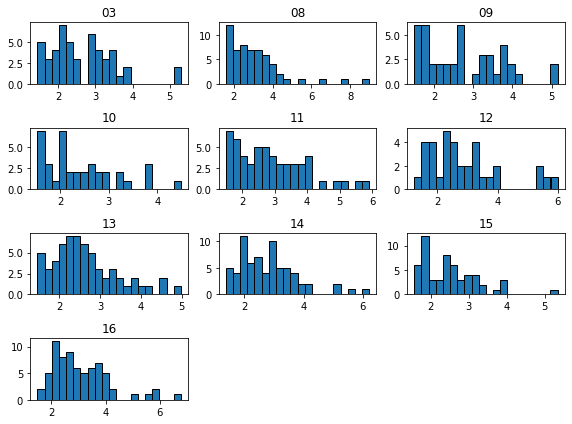

In [32]:
fig, ax1 = plt.subplots(figsize=(8, 6))
df['length'].hist(by=df['speaker'], xrot=0, ax=ax1, bins=20, edgecolor='black')
plt.tight_layout()
plt.show()

In [33]:
df.groupby('speaker')['emotion'].describe()['count']

speaker
03    49
08    58
09    43
10    38
11    55
12    35
13    61
14    69
15    56
16    71
Name: count, dtype: object

We see that the distribution of texts by speaker is roughly uniform. This is good since a given speaker may introduce bias in recordings if his audio samples overwhelm the others.

In [34]:
rate = []
for file in df.filename:
    sr, _ = wavfile.read(f'{path}/{file}')
    rate.append(sr)
    
np.unique(rate)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  This is separate from the ipykernel package so we can avoid doing imports until


array([16000])

We only have 16 kHz audio files.

# Feature Engineering & Modeling

In this first modelling approach, we will extract the mfccs from the data and use these as features as mentionned in the 'Data Preparation and Cleaning' section.

We will also augment the data by varying time (lenghtening/shortening audio) and pitch. We will only augment the training and validation data to avoid information leakage into the test set.

### vary time

In [35]:
for file in os.listdir('../data/wav'):
    y, sr = librosa.load(f'../data/wav/{file}')
    y_changed = librosa.effects.time_stretch(y, rate=0.80)
    wavfile.write(filename=f'../data/aug/{file.split(".")[0]}_fast.wav', rate=sr, data=y_changed)
    
for file in os.listdir('../data/wav'):
    y, sr = librosa.load(f'../data/wav/{file}')
    y_changed = librosa.effects.time_stretch(y, rate=1.20)
    wavfile.write(filename=f'../data/aug/{file.split(".")[0]}_slow.wav', rate=sr, data=y_changed)

We can compare the difference between the raw sample and a lengthened file.

In [36]:
# raw file
ipd.Audio(y, rate=sr)

In [37]:
# augmented file
ipd.Audio(y_changed, rate=sr)

### vary pitch

In [38]:
steps = [-2.5, -2, -1.5, -1, -0.5, 0.5,  1, 1.5, 2, 2.5]

for n_step in steps:
    for file in os.listdir('../data/wav'):
        y, sr = librosa.load(f'../data/wav/{file}')
        y_changed = librosa.effects.pitch_shift(y, sr, n_steps=n_step)
        wavfile.write(filename=f'../data/aug/{file.split(".")[0]}_pitch_{n_step}.wav', rate=sr, data=y_changed)

### downsampling

Downsample to 8 kHz.

In [39]:
for file in os.listdir('../data/wav'):
    y, sr = librosa.load(f'../data/wav/{file}', sr=8000)
    wavfile.write(filename=f'../data/aug/{file}_downsampled_8khz.wav', rate=sr, data=y)

The augmented dataset consists of:

- 535 normal samples.
- 2675 samples 'positively' pitched modulated 0.5 or more semitones higher.
- 2675 samples 'negatively' pitched modulated 0.5 or more semitones lower.
- 535 samples Slowed down to 0.80.
- 535 samples speed up by 1.20.
- 535 samples downsampled to 8 kHz.

Totalling 6955 samples.

### Remove audio "deadspace"

We compute the envelope of the signal (the estimation of signal magnitude). If the signal is below the envelope, we consider the audio has died out and remove it.

In [40]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(0.1*rate), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [41]:
for file in os.listdir('../data/aug'):
    signal, sr = librosa.load(f'../data/aug/{file}', sr=16000)
    mask = envelope(signal, sr, 0.0005)
    signal = signal[mask]
    wavfile.write(filename=f'../data/aug/{file}', rate=sr, data=signal)

### mfccs

In [44]:
lst = []
for file in glob.glob('../data/wav/*.wav'):
    
    data, sampling_rate = librosa.load(file, res_type='kaiser_fast')
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40), axis=1)
    file = file.split('/')[-1]
    arr = mfccs, file[5]
    lst.append(arr)

In [45]:
X, y = zip(*lst)
y_test = np.asarray(y)
X_test = np.asarray(X)
print(X_test.shape, y_test.shape)

(535, 40) (535,)


This is the raw data. We will keep this as the test set. Below, we will construct the training/val sets with augmented data.

In [46]:
lst = []
for file in glob.glob('../data/aug/*.wav'):
    
    data, sampling_rate = librosa.load(file, res_type='kaiser_fast')
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40), axis=1)
    file = file.split('/')[-1]
    arr = mfccs, file[5]
    lst.append(arr)

We get 40 mfccs per audio file, with each mfcc containing 112 values/features. We then take the mean value of each mfcc feature, to obtain 40 mfccs for each audio file

In [47]:
X, y = zip(*lst)
y = np.asarray(y)
X = np.asarray(X)

### Train/Test split

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [49]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(5564, 40) (1391, 40) (535, 40)
(5564,) (1391,) (535,)


Since the augmentation process is long, we save the final dataset as a pickle for quick loading in the future.

In [50]:
pickle_data = PickleDataset()
pickle_data.train = (X_train, y_train)
pickle_data.val = (X_val, y_val)
pickle_data.test = (X_test, y_test)

In [51]:
with open('../pickles/data.pkl', 'wb') as handle:
        # for compatibility with python 2: protocol=2
        pickle.dump(pickle_data, handle, protocol=2)

### load data

In [52]:
with open('../pickles/data.pkl', 'rb') as handle:
    data = pickle.load(handle)

X_train, y_train = zip(data.train)
X_train, y_train = np.array(X_train)[0], np.array(y_train)[0]
X_val, y_val = zip(data.val)
X_val, y_val = np.array(X_val)[0], np.array(y_val)[0]
X_test, y_test = zip(data.test)
X_test, y_test = np.array(X_test)[0], np.array(y_test)[0]

# Results & Visualizations

### Multinomial Regression

In [53]:
train_samples = X_train.shape[0]
mnr = LogisticRegression(multi_class='ovr',
                         solver='saga', tol=0.1).fit(X_train, y_train)

predictions = mnr.predict(X_test)
score = mnr.score(X_test, y_test)
print("Test score with: %.4f" % score)

Test score with: 0.6879


In [54]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           A       0.64      0.68      0.66        69
           E       0.74      0.61      0.67        46
           F       0.56      0.56      0.56        71
           L       0.69      0.38      0.49        81
           N       0.56      0.72      0.63        79
           T       0.73      0.89      0.80        62
           W       0.85      0.87      0.86       127

    accuracy                           0.69       535
   macro avg       0.68      0.67      0.67       535
weighted avg       0.69      0.69      0.68       535



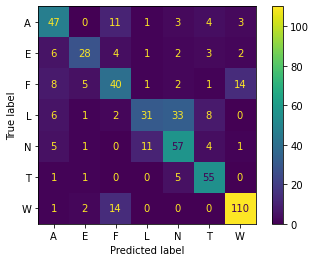

In [55]:
plot_confusion_matrix(mnr, X_test, y_test)
plt.show()

### kNN

In [56]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='auto',
                          leaf_size=5, metric='euclidean').fit(X_train, y_train)
predictions = knn.predict(X_test)
score = knn.score(X_test, y_test)

print("Test score: %.4f" % score)

Test score: 0.9720


In [57]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           A       1.00      0.96      0.98        69
           E       0.96      1.00      0.98        46
           F       0.99      0.99      0.99        71
           L       0.96      0.93      0.94        81
           N       0.96      0.97      0.97        79
           T       0.91      0.97      0.94        62
           W       1.00      0.99      1.00       127

    accuracy                           0.97       535
   macro avg       0.97      0.97      0.97       535
weighted avg       0.97      0.97      0.97       535



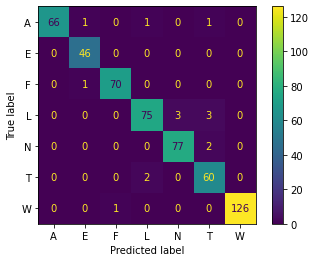

In [58]:
plot_confusion_matrix(knn, X_test, y_test)
plt.show()

### save kNN model

In [59]:
with open('../pickles/knn.pkl', 'wb') as model_pkl:
    pickle.dump(knn, model_pkl)

### CV

In [60]:
parameters = {'n_neighbors':[3, 5, 10, 15, 20, 30, 40, 50], 'weights':('uniform', 'distance'),
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size': np.arange(5, 50, 5),
             'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}

In [61]:
clf = GridSearchCV(knn, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(leaf_size=5, metric='euclidean',
                                            n_neighbors=3, weights='distance'),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45]),
                         'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'minkowski'],
                         'n_neighbors': [3, 5, 10, 15, 20, 30, 40, 50],
                         'weights': ('uniform', 'distance')})

In [62]:
clf.best_params_

{'algorithm': 'auto',
 'leaf_size': 5,
 'metric': 'manhattan',
 'n_neighbors': 3,
 'weights': 'distance'}

In [63]:
clf.best_score_

0.9399703956511342

In [64]:
clf.cv_results_['mean_test_score']

array([0.92972862, 0.93817636, 0.91588988, ..., 0.81470053, 0.72915075,
       0.7945707 ])

### Decision Tree

In [65]:
dtree = DecisionTreeClassifier().fit(X_train, y_train)
predictions = dtree.predict(X_test)
score = dtree.score(X_test, y_test)

print("Test score: %.4f" % score)

Test score: 0.7234


In [66]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           A       0.74      0.74      0.74        69
           E       0.62      0.61      0.62        46
           F       0.55      0.72      0.62        71
           L       0.68      0.78      0.73        81
           N       0.80      0.70      0.74        79
           T       0.82      0.90      0.86        62
           W       0.84      0.65      0.73       127

    accuracy                           0.72       535
   macro avg       0.72      0.73      0.72       535
weighted avg       0.74      0.72      0.73       535



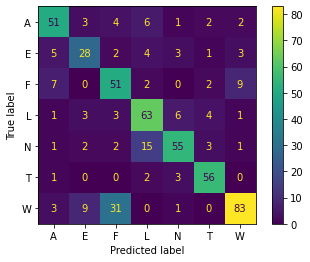

In [67]:
plot_confusion_matrix(dtree, X_test, y_test)
plt.show()

### Random Forest

In [68]:
rforest = RandomForestClassifier(criterion='gini', max_depth=10, max_features='log2',
                                max_leaf_nodes=100, min_samples_leaf=3, min_samples_split=20,
                                n_estimators=22000, random_state=42).fit(X_train, y_train)

predictions = rforest.predict(X_test)
score = rforest.score(X_test, y_test)
print("Test score: %.4f" % score)

Test score: 0.8748


In [69]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           A       0.92      0.83      0.87        69
           E       0.95      0.83      0.88        46
           F       0.83      0.73      0.78        71
           L       0.83      0.91      0.87        81
           N       0.91      0.87      0.89        79
           T       0.90      0.98      0.94        62
           W       0.85      0.92      0.89       127

    accuracy                           0.87       535
   macro avg       0.88      0.87      0.87       535
weighted avg       0.88      0.87      0.87       535



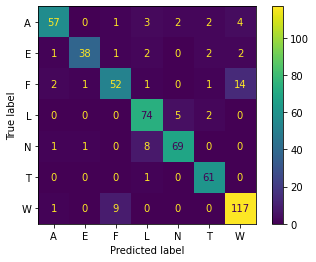

In [70]:
plot_confusion_matrix(rforest, X_test, y_test)
plt.show()

### SVM

In [71]:
svm = svm.SVC(gamma=0.001, C=100.).fit(X_train, y_train)
predictions = svm.predict(X_test)
score = svm.score(X_test, y_test)

print("Test score: %.4f" % score)

Test score: 0.9832


In [72]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           A       0.99      1.00      0.99        69
           E       1.00      0.98      0.99        46
           F       1.00      1.00      1.00        71
           L       0.97      0.93      0.95        81
           N       0.94      0.97      0.96        79
           T       0.98      1.00      0.99        62
           W       1.00      1.00      1.00       127

    accuracy                           0.98       535
   macro avg       0.98      0.98      0.98       535
weighted avg       0.98      0.98      0.98       535



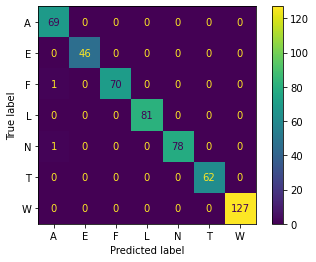

In [73]:
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

### Bagging

In [74]:
svc = SVC()
svm_bag = BaggingClassifier(base_estimator=svc,
                             n_estimators=100, random_state=0).fit(X_train, y_train)
predictions = svm_bag.predict(X_test)
score = svm_bag.score(X_test, y_test)

print("Test score: %.4f" % score)

Test score: 0.6860


In [75]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           A       0.54      0.81      0.65        69
           E       0.83      0.52      0.64        46
           F       0.63      0.52      0.57        71
           L       0.52      0.64      0.57        81
           N       0.68      0.49      0.57        79
           T       0.81      0.82      0.82        62
           W       0.87      0.85      0.86       127

    accuracy                           0.69       535
   macro avg       0.70      0.67      0.67       535
weighted avg       0.70      0.69      0.69       535



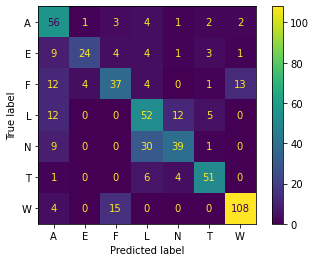

In [76]:
plot_confusion_matrix(svm_bag, X_test, y_test)
plt.show()

### Boosting/XGBoost

In [77]:
gboost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
         max_depth=1, random_state=0).fit(X_train, y_train)
predictions = gboost.predict(X_test)
score = gboost.score(X_test, y_test)

print("Test score: %.4f" % score)

Test score: 0.7794


In [78]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           A       0.65      0.74      0.69        69
           E       0.82      0.78      0.80        46
           F       0.63      0.72      0.67        71
           L       0.73      0.77      0.75        81
           N       0.78      0.73      0.76        79
           T       0.92      0.92      0.92        62
           W       0.92      0.80      0.86       127

    accuracy                           0.78       535
   macro avg       0.78      0.78      0.78       535
weighted avg       0.79      0.78      0.78       535



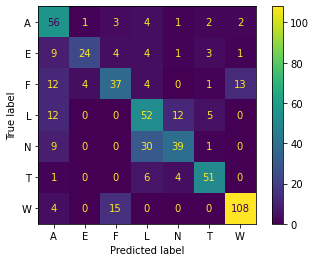

In [79]:
plot_confusion_matrix(svm_bag, X_test, y_test)
plt.show()

### Bagged kNN

In [80]:
bagging_knn = BaggingClassifier(KNeighborsClassifier(),
                                 max_samples=0.5, max_features=0.5).fit(X_train, y_train)

predictions = bagging_knn.predict(X_test)
score = bagging_knn.score(X_test, y_test)

print("Test score: %.4f" % score)

Test score: 0.9570


In [81]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           A       0.98      0.94      0.96        69
           E       0.94      0.98      0.96        46
           F       0.99      0.93      0.96        71
           L       0.95      0.91      0.93        81
           N       0.94      0.94      0.94        79
           T       0.93      1.00      0.96        62
           W       0.97      0.99      0.98       127

    accuracy                           0.96       535
   macro avg       0.96      0.96      0.96       535
weighted avg       0.96      0.96      0.96       535



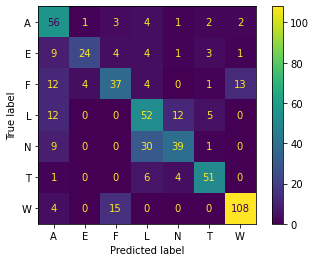

In [82]:
plot_confusion_matrix(svm_bag, X_test, y_test)
plt.show()

### CNN conv1d - Keras

In [83]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_valcnn = np.expand_dims(X_val, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [84]:
x_traincnn.shape, x_valcnn.shape, x_testcnn.shape

((5564, 40, 1), (1391, 40, 1), (535, 40, 1))

### 1. no scale:

### model 1

In [106]:
model = Sequential()

model.add(Conv1D(256, 5, padding='same',input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(7))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 40, 256)           1536      
_________________________________________________________________
activation_16 (Activation)   (None, 40, 256)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 40, 128)           163968    
_________________________________________________________________
activation_17 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 5, 128)           

In [86]:
y_train[y_train == 'W'] = 0
y_train[y_train == 'L'] = 1
y_train[y_train == 'E'] = 2
y_train[y_train == 'A'] = 3
y_train[y_train == 'F'] = 4
y_train[y_train == 'T'] = 5
y_train[y_train == 'N'] = 6

y_test[y_test == 'W'] = 0
y_test[y_test == 'L'] = 1
y_test[y_test == 'E'] = 2
y_test[y_test == 'A'] = 3
y_test[y_test == 'F'] = 4
y_test[y_test == 'T'] = 5
y_test[y_test == 'N'] = 6

y_val[y_val == 'W'] = 0
y_val[y_val == 'L'] = 1
y_val[y_val == 'E'] = 2
y_val[y_val == 'A'] = 3
y_val[y_val == 'F'] = 4
y_val[y_val == 'T'] = 5
y_val[y_val == 'N'] = 6

In [87]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
checkpoint = ModelCheckpoint('../models/conv1d/model.{epoch:02d}-{accuracy:.4f}-{val_accuracy:.4f}-{loss:.4f}-{val_loss:.4f}.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True,
                            save_weights_only=False, period=1)

In [88]:
#history = model.fit(x_traincnn, y_train, batch_size=256, epochs=250, validation_data=(x_valcnn, y_val),
#                   callbacks=[checkpoint])

history = model.fit(x_traincnn, y_train, batch_size=256, epochs=250, validation_data=(x_valcnn, y_val))

Train on 5564 samples, validate on 1391 samples
Epoch 1/250
5564/5564 [==============================] - 4s 741us/step - loss: 2.6676 - accuracy: 0.1120 - val_loss: 1.8730 - val_accuracy: 0.2825
Epoch 2/250
5564/5564 [==============================] - 0s 34us/step - loss: 1.8278 - accuracy: 0.2759 - val_loss: 1.6807 - val_accuracy: 0.3551
Epoch 3/250
5564/5564 [==============================] - 0s 33us/step - loss: 1.6741 - accuracy: 0.3411 - val_loss: 1.5613 - val_accuracy: 0.4062
Epoch 4/250
5564/5564 [==============================] - 0s 33us/step - loss: 1.5688 - accuracy: 0.3852 - val_loss: 1.4646 - val_accuracy: 0.4630
Epoch 5/250
5564/5564 [==============================] - 0s 33us/step - loss: 1.4752 - accuracy: 0.4206 - val_loss: 1.3941 - val_accuracy: 0.4709
Epoch 6/250
5564/5564 [==============================] - 0s 34us/step - loss: 1.3998 - accuracy: 0.4527 - val_loss: 1.3318 - val_accuracy: 0.4853
Epoch 7/250
5564/5564 [==============================] - 0s 33us/step - los

5564/5564 [==============================] - 0s 34us/step - loss: 0.6846 - accuracy: 0.7347 - val_loss: 0.6968 - val_accuracy: 0.7405
Epoch 57/250
5564/5564 [==============================] - 0s 34us/step - loss: 0.6777 - accuracy: 0.7358 - val_loss: 0.6911 - val_accuracy: 0.7383
Epoch 58/250
5564/5564 [==============================] - 0s 33us/step - loss: 0.6732 - accuracy: 0.7407 - val_loss: 0.6954 - val_accuracy: 0.7455
Epoch 59/250
5564/5564 [==============================] - 0s 34us/step - loss: 0.6715 - accuracy: 0.7412 - val_loss: 0.6878 - val_accuracy: 0.7462
Epoch 60/250
5564/5564 [==============================] - 0s 33us/step - loss: 0.6636 - accuracy: 0.7453 - val_loss: 0.6827 - val_accuracy: 0.7570
Epoch 61/250
5564/5564 [==============================] - 0s 33us/step - loss: 0.6603 - accuracy: 0.7507 - val_loss: 0.6745 - val_accuracy: 0.7556
Epoch 62/250
5564/5564 [==============================] - 0s 33us/step - loss: 0.6554 - accuracy: 0.7473 - val_loss: 0.6691 - val_a

Epoch 112/250
5564/5564 [==============================] - 0s 33us/step - loss: 0.4988 - accuracy: 0.8127 - val_loss: 0.5375 - val_accuracy: 0.8009
Epoch 113/250
5564/5564 [==============================] - 0s 33us/step - loss: 0.4971 - accuracy: 0.8063 - val_loss: 0.5304 - val_accuracy: 0.8052
Epoch 114/250
5564/5564 [==============================] - 0s 33us/step - loss: 0.4943 - accuracy: 0.8183 - val_loss: 0.5305 - val_accuracy: 0.7958
Epoch 115/250
5564/5564 [==============================] - 0s 33us/step - loss: 0.4912 - accuracy: 0.8178 - val_loss: 0.5266 - val_accuracy: 0.8023
Epoch 116/250
5564/5564 [==============================] - 0s 33us/step - loss: 0.4859 - accuracy: 0.8205 - val_loss: 0.5465 - val_accuracy: 0.7987
Epoch 117/250
5564/5564 [==============================] - 0s 33us/step - loss: 0.4886 - accuracy: 0.8163 - val_loss: 0.5347 - val_accuracy: 0.7886
Epoch 118/250
5564/5564 [==============================] - 0s 33us/step - loss: 0.4875 - accuracy: 0.8156 - val_

5564/5564 [==============================] - 0s 33us/step - loss: 0.3995 - accuracy: 0.8515 - val_loss: 0.4507 - val_accuracy: 0.8325
Epoch 168/250
5564/5564 [==============================] - 0s 33us/step - loss: 0.3965 - accuracy: 0.8557 - val_loss: 0.4488 - val_accuracy: 0.8289
Epoch 169/250
5564/5564 [==============================] - 0s 33us/step - loss: 0.3982 - accuracy: 0.8530 - val_loss: 0.4392 - val_accuracy: 0.8397
Epoch 170/250
5564/5564 [==============================] - 0s 33us/step - loss: 0.3900 - accuracy: 0.8568 - val_loss: 0.4440 - val_accuracy: 0.8382
Epoch 171/250
5564/5564 [==============================] - 0s 33us/step - loss: 0.3934 - accuracy: 0.8623 - val_loss: 0.4437 - val_accuracy: 0.8397
Epoch 172/250
5564/5564 [==============================] - 0s 33us/step - loss: 0.3928 - accuracy: 0.8559 - val_loss: 0.4422 - val_accuracy: 0.8339
Epoch 173/250
5564/5564 [==============================] - 0s 33us/step - loss: 0.3981 - accuracy: 0.8460 - val_loss: 0.4343 -

5564/5564 [==============================] - 0s 34us/step - loss: 0.3330 - accuracy: 0.8817 - val_loss: 0.3823 - val_accuracy: 0.8620
Epoch 223/250
5564/5564 [==============================] - 0s 34us/step - loss: 0.3303 - accuracy: 0.8817 - val_loss: 0.3818 - val_accuracy: 0.8656
Epoch 224/250
5564/5564 [==============================] - 0s 34us/step - loss: 0.3275 - accuracy: 0.8868 - val_loss: 0.3887 - val_accuracy: 0.8656
Epoch 225/250
5564/5564 [==============================] - 0s 34us/step - loss: 0.3279 - accuracy: 0.8855 - val_loss: 0.3858 - val_accuracy: 0.8756
Epoch 226/250
5564/5564 [==============================] - 0s 34us/step - loss: 0.3271 - accuracy: 0.8780 - val_loss: 0.3778 - val_accuracy: 0.8684
Epoch 227/250
5564/5564 [==============================] - 0s 34us/step - loss: 0.3242 - accuracy: 0.8834 - val_loss: 0.3766 - val_accuracy: 0.8728
Epoch 228/250
5564/5564 [==============================] - 0s 34us/step - loss: 0.3281 - accuracy: 0.8830 - val_loss: 0.3883 -

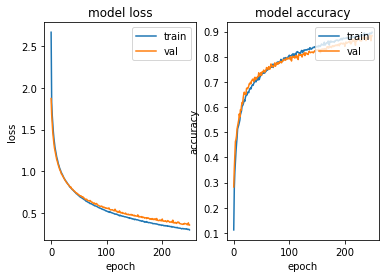

In [89]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper right')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('model accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper right')

plt.show()

In [90]:
score = model.evaluate(x=x_testcnn, y=y_test)
predictions = model.predict(x_testcnn)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

535/535 [==============================] - 0s 153us/step
Test loss: 0.3051721656990943
Test accuracy: 0.9121495485305786


In [92]:
print(classification_report(classes[np.argmax(y_test, axis=1)], classes[np.argmax(predictions, axis=1)]))

              precision    recall  f1-score   support

           A       0.98      0.94      0.96       127
           E       0.97      0.72      0.82        81
           F       0.96      0.96      0.96        46
           L       0.87      0.97      0.92        69
           N       0.94      0.89      0.91        71
           T       0.91      1.00      0.95        62
           W       0.78      0.95      0.86        79

    accuracy                           0.91       535
   macro avg       0.92      0.92      0.91       535
weighted avg       0.92      0.91      0.91       535



### 2. standard scale:

In [93]:
x_traincnn.shape

(5564, 40, 1)

In [94]:
scaler = StandardScaler()
scaler.fit(x_traincnn.reshape(x_traincnn.shape[0], x_traincnn.shape[1]))

x_traincnn_scaled = scaler.transform(x_traincnn.reshape(x_traincnn.shape[0], x_traincnn.shape[1]))
x_traincnn_scaled = np.expand_dims(x_traincnn_scaled, 2)

x_valcnn_scaled = scaler.transform(x_valcnn.reshape(x_valcnn.shape[0], x_valcnn.shape[1]))
x_valcnn_scaled = np.expand_dims(x_valcnn_scaled, 2)

x_testcnn_scaled = scaler.transform(x_testcnn.reshape(x_testcnn.shape[0], x_testcnn.shape[1]))
x_testcnn_scaled = np.expand_dims(x_testcnn_scaled, 2)


In [101]:
history = model.fit(x_traincnn_scaled, y_train, batch_size=512, epochs=350, validation_data=(x_valcnn_scaled, y_val))

Train on 5564 samples, validate on 1391 samples
Epoch 1/350
5564/5564 [==============================] - 0s 73us/step - loss: 1.9318 - accuracy: 0.2757 - val_loss: 1.9271 - val_accuracy: 0.3134
Epoch 2/350
5564/5564 [==============================] - 0s 26us/step - loss: 1.9199 - accuracy: 0.3136 - val_loss: 1.9176 - val_accuracy: 0.3048
Epoch 3/350
5564/5564 [==============================] - 0s 25us/step - loss: 1.9101 - accuracy: 0.2948 - val_loss: 1.9089 - val_accuracy: 0.2904
Epoch 4/350
5564/5564 [==============================] - 0s 25us/step - loss: 1.9007 - accuracy: 0.2870 - val_loss: 1.8999 - val_accuracy: 0.2818
Epoch 5/350
5564/5564 [==============================] - 0s 25us/step - loss: 1.8909 - accuracy: 0.2840 - val_loss: 1.8909 - val_accuracy: 0.2782
Epoch 6/350
5564/5564 [==============================] - 0s 25us/step - loss: 1.8811 - accuracy: 0.2859 - val_loss: 1.8816 - val_accuracy: 0.2797
Epoch 7/350
5564/5564 [==============================] - 0s 25us/step - loss

5564/5564 [==============================] - 0s 25us/step - loss: 1.2268 - accuracy: 0.5207 - val_loss: 1.2504 - val_accuracy: 0.5025
Epoch 57/350
5564/5564 [==============================] - 0s 25us/step - loss: 1.2195 - accuracy: 0.5246 - val_loss: 1.2427 - val_accuracy: 0.5061
Epoch 58/350
5564/5564 [==============================] - 0s 25us/step - loss: 1.2114 - accuracy: 0.5266 - val_loss: 1.2349 - val_accuracy: 0.5183
Epoch 59/350
5564/5564 [==============================] - 0s 25us/step - loss: 1.2038 - accuracy: 0.5336 - val_loss: 1.2278 - val_accuracy: 0.5212
Epoch 60/350
5564/5564 [==============================] - 0s 25us/step - loss: 1.1962 - accuracy: 0.5347 - val_loss: 1.2207 - val_accuracy: 0.5234
Epoch 61/350
5564/5564 [==============================] - 0s 25us/step - loss: 1.1894 - accuracy: 0.5394 - val_loss: 1.2140 - val_accuracy: 0.5248
Epoch 62/350
5564/5564 [==============================] - 0s 25us/step - loss: 1.1821 - accuracy: 0.5397 - val_loss: 1.2071 - val_a

Epoch 112/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.9733 - accuracy: 0.6314 - val_loss: 1.0132 - val_accuracy: 0.6175
Epoch 113/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.9704 - accuracy: 0.6341 - val_loss: 1.0126 - val_accuracy: 0.6132
Epoch 114/350
5564/5564 [==============================] - 0s 26us/step - loss: 0.9674 - accuracy: 0.6314 - val_loss: 1.0086 - val_accuracy: 0.6240
Epoch 115/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.9645 - accuracy: 0.6364 - val_loss: 1.0063 - val_accuracy: 0.6204
Epoch 116/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.9621 - accuracy: 0.6330 - val_loss: 1.0036 - val_accuracy: 0.6226
Epoch 117/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.9587 - accuracy: 0.6398 - val_loss: 1.0012 - val_accuracy: 0.6254
Epoch 118/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.9558 - accuracy: 0.6395 - val_

5564/5564 [==============================] - 0s 25us/step - loss: 0.8383 - accuracy: 0.6828 - val_loss: 0.8899 - val_accuracy: 0.6614
Epoch 168/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.8365 - accuracy: 0.6830 - val_loss: 0.8900 - val_accuracy: 0.6607
Epoch 169/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.8338 - accuracy: 0.6842 - val_loss: 0.8865 - val_accuracy: 0.6686
Epoch 170/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.8330 - accuracy: 0.6846 - val_loss: 0.8841 - val_accuracy: 0.6686
Epoch 171/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.8307 - accuracy: 0.6862 - val_loss: 0.8839 - val_accuracy: 0.6614
Epoch 172/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.8290 - accuracy: 0.6849 - val_loss: 0.8819 - val_accuracy: 0.6664
Epoch 173/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.8278 - accuracy: 0.6851 - val_loss: 0.8804 -

5564/5564 [==============================] - 0s 25us/step - loss: 0.7429 - accuracy: 0.7157 - val_loss: 0.7972 - val_accuracy: 0.6988
Epoch 223/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.7398 - accuracy: 0.7157 - val_loss: 0.7969 - val_accuracy: 0.6923
Epoch 224/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.7387 - accuracy: 0.7182 - val_loss: 0.7961 - val_accuracy: 0.6923
Epoch 225/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.7377 - accuracy: 0.7162 - val_loss: 0.7959 - val_accuracy: 0.6945
Epoch 226/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.7358 - accuracy: 0.7173 - val_loss: 0.7914 - val_accuracy: 0.7024
Epoch 227/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.7346 - accuracy: 0.7157 - val_loss: 0.7907 - val_accuracy: 0.6959
Epoch 228/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.7333 - accuracy: 0.7212 - val_loss: 0.7889 -

5564/5564 [==============================] - 0s 25us/step - loss: 0.6647 - accuracy: 0.7495 - val_loss: 0.7245 - val_accuracy: 0.7290
Epoch 278/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.6623 - accuracy: 0.7487 - val_loss: 0.7223 - val_accuracy: 0.7340
Epoch 279/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.6611 - accuracy: 0.7495 - val_loss: 0.7216 - val_accuracy: 0.7290
Epoch 280/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.6598 - accuracy: 0.7507 - val_loss: 0.7238 - val_accuracy: 0.7182
Epoch 281/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.6584 - accuracy: 0.7466 - val_loss: 0.7202 - val_accuracy: 0.7290
Epoch 282/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.6582 - accuracy: 0.7507 - val_loss: 0.7171 - val_accuracy: 0.7362
Epoch 283/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.6544 - accuracy: 0.7522 - val_loss: 0.7148 -

5564/5564 [==============================] - 0s 25us/step - loss: 0.5938 - accuracy: 0.7816 - val_loss: 0.6627 - val_accuracy: 0.7462
Epoch 333/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.5924 - accuracy: 0.7836 - val_loss: 0.6595 - val_accuracy: 0.7520
Epoch 334/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.5909 - accuracy: 0.7804 - val_loss: 0.6568 - val_accuracy: 0.7570
Epoch 335/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.5915 - accuracy: 0.7806 - val_loss: 0.6575 - val_accuracy: 0.7556
Epoch 336/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.5896 - accuracy: 0.7822 - val_loss: 0.6533 - val_accuracy: 0.7527
Epoch 337/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.5875 - accuracy: 0.7798 - val_loss: 0.6555 - val_accuracy: 0.7534
Epoch 338/350
5564/5564 [==============================] - 0s 25us/step - loss: 0.5885 - accuracy: 0.7818 - val_loss: 0.6523 -

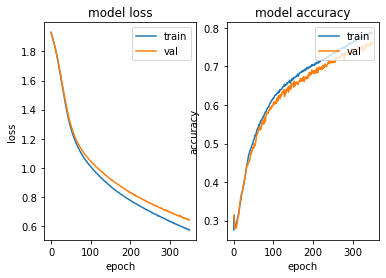

In [102]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper right')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('model accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper right')

plt.show()

In [103]:
score = model.evaluate(x=x_testcnn_scaled, y=y_test)
predictions = model.predict(x_testcnn_scaled)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

535/535 [==============================] - 0s 66us/step
Test loss: 0.6338018636837184
Test accuracy: 0.7738317847251892


In [104]:
print(classification_report(classes[np.argmax(y_test, axis=1)], classes[np.argmax(predictions, axis=1)]))

              precision    recall  f1-score   support

           A       0.94      0.81      0.87       127
           E       0.70      0.84      0.76        81
           F       0.77      0.65      0.71        46
           L       0.78      0.81      0.79        69
           N       0.64      0.63      0.64        71
           T       0.70      0.98      0.82        62
           W       0.84      0.65      0.73        79

    accuracy                           0.77       535
   macro avg       0.77      0.77      0.76       535
weighted avg       0.79      0.77      0.77       535



### 3. minmax scale:

In [105]:
scaler = MinMaxScaler()
scaler.fit(x_traincnn[:,:,0])
x_traincnn_scaled = scaler.transform(x_traincnn[:,:,0])
x_traincnn_scaled = x_traincnn_scaled.reshape(x_traincnn_scaled.shape[0], x_traincnn_scaled.shape[1], 1)

x_valcnn_scaled = scaler.transform(x_valcnn[:,:,0])
x_valcnn_scaled = x_valcnn_scaled.reshape(x_valcnn_scaled.shape[0], x_valcnn_scaled.shape[1], 1)

x_testcnn_scaled = scaler.transform(x_testcnn[:,:,0])
x_testcnn_scaled = x_testcnn_scaled.reshape(x_testcnn_scaled.shape[0], x_testcnn_scaled.shape[1], 1)

In [107]:
history = model.fit(x_traincnn_scaled, y_train, batch_size=256, epochs=350, validation_data=(x_valcnn_scaled, y_val))

Train on 5564 samples, validate on 1391 samples
Epoch 1/350
5564/5564 [==============================] - 0s 81us/step - loss: 1.9388 - accuracy: 0.2471 - val_loss: 1.9368 - val_accuracy: 0.2358
Epoch 2/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.9322 - accuracy: 0.2389 - val_loss: 1.9310 - val_accuracy: 0.2344
Epoch 3/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.9256 - accuracy: 0.2381 - val_loss: 1.9250 - val_accuracy: 0.2344
Epoch 4/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.9189 - accuracy: 0.2381 - val_loss: 1.9185 - val_accuracy: 0.2344
Epoch 5/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.9120 - accuracy: 0.2381 - val_loss: 1.9123 - val_accuracy: 0.2344
Epoch 6/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.9052 - accuracy: 0.2381 - val_loss: 1.9058 - val_accuracy: 0.2344
Epoch 7/350
5564/5564 [==============================] - 0s 33us/step - loss

5564/5564 [==============================] - 0s 33us/step - loss: 1.5149 - accuracy: 0.3877 - val_loss: 1.5167 - val_accuracy: 0.3904
Epoch 57/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.5105 - accuracy: 0.3904 - val_loss: 1.5136 - val_accuracy: 0.3925
Epoch 58/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.5063 - accuracy: 0.3902 - val_loss: 1.5076 - val_accuracy: 0.3997
Epoch 59/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.5016 - accuracy: 0.3947 - val_loss: 1.5024 - val_accuracy: 0.3968
Epoch 60/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.4980 - accuracy: 0.3963 - val_loss: 1.4994 - val_accuracy: 0.3983
Epoch 61/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.4939 - accuracy: 0.3963 - val_loss: 1.4949 - val_accuracy: 0.4004
Epoch 62/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.4899 - accuracy: 0.3974 - val_loss: 1.4902 - val_a

Epoch 112/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.2787 - accuracy: 0.5068 - val_loss: 1.2762 - val_accuracy: 0.5032
Epoch 113/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.2739 - accuracy: 0.5093 - val_loss: 1.2718 - val_accuracy: 0.5047
Epoch 114/350
5564/5564 [==============================] - 0s 34us/step - loss: 1.2691 - accuracy: 0.5131 - val_loss: 1.2662 - val_accuracy: 0.5090
Epoch 115/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.2661 - accuracy: 0.5110 - val_loss: 1.2643 - val_accuracy: 0.5040
Epoch 116/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.2626 - accuracy: 0.5146 - val_loss: 1.2599 - val_accuracy: 0.5140
Epoch 117/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.2579 - accuracy: 0.5115 - val_loss: 1.2557 - val_accuracy: 0.5133
Epoch 118/350
5564/5564 [==============================] - 0s 34us/step - loss: 1.2536 - accuracy: 0.5217 - val_

5564/5564 [==============================] - 0s 33us/step - loss: 1.0998 - accuracy: 0.5737 - val_loss: 1.1029 - val_accuracy: 0.5715
Epoch 168/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.0974 - accuracy: 0.5787 - val_loss: 1.0962 - val_accuracy: 0.5780
Epoch 169/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.0944 - accuracy: 0.5775 - val_loss: 1.0972 - val_accuracy: 0.5737
Epoch 170/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.0931 - accuracy: 0.5717 - val_loss: 1.0917 - val_accuracy: 0.5780
Epoch 171/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.0919 - accuracy: 0.5769 - val_loss: 1.0911 - val_accuracy: 0.5758
Epoch 172/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.0885 - accuracy: 0.5791 - val_loss: 1.0889 - val_accuracy: 0.5787
Epoch 173/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.0858 - accuracy: 0.5821 - val_loss: 1.0925 -

5564/5564 [==============================] - 0s 33us/step - loss: 1.0016 - accuracy: 0.6159 - val_loss: 1.0102 - val_accuracy: 0.6089
Epoch 223/350
5564/5564 [==============================] - 0s 33us/step - loss: 1.0015 - accuracy: 0.6118 - val_loss: 1.0054 - val_accuracy: 0.6075
Epoch 224/350
5564/5564 [==============================] - 0s 33us/step - loss: 0.9994 - accuracy: 0.6141 - val_loss: 1.0035 - val_accuracy: 0.6161
Epoch 225/350
5564/5564 [==============================] - 0s 33us/step - loss: 0.9988 - accuracy: 0.6143 - val_loss: 1.0034 - val_accuracy: 0.6111
Epoch 226/350
5564/5564 [==============================] - 0s 33us/step - loss: 0.9948 - accuracy: 0.6114 - val_loss: 1.0004 - val_accuracy: 0.6139
Epoch 227/350
5564/5564 [==============================] - 0s 33us/step - loss: 0.9962 - accuracy: 0.6150 - val_loss: 1.0010 - val_accuracy: 0.6168
Epoch 228/350
5564/5564 [==============================] - 0s 33us/step - loss: 0.9955 - accuracy: 0.6156 - val_loss: 0.9988 -

5564/5564 [==============================] - 0s 33us/step - loss: 0.9419 - accuracy: 0.6370 - val_loss: 0.9483 - val_accuracy: 0.6362
Epoch 278/350
5564/5564 [==============================] - 0s 33us/step - loss: 0.9373 - accuracy: 0.6402 - val_loss: 0.9463 - val_accuracy: 0.6391
Epoch 279/350
5564/5564 [==============================] - 0s 33us/step - loss: 0.9399 - accuracy: 0.6391 - val_loss: 0.9485 - val_accuracy: 0.6326
Epoch 280/350
5564/5564 [==============================] - 0s 33us/step - loss: 0.9378 - accuracy: 0.6386 - val_loss: 0.9500 - val_accuracy: 0.6341
Epoch 281/350
5564/5564 [==============================] - 0s 33us/step - loss: 0.9376 - accuracy: 0.6380 - val_loss: 0.9472 - val_accuracy: 0.6391
Epoch 282/350
5564/5564 [==============================] - 0s 33us/step - loss: 0.9352 - accuracy: 0.6404 - val_loss: 0.9428 - val_accuracy: 0.6413
Epoch 283/350
5564/5564 [==============================] - 0s 33us/step - loss: 0.9368 - accuracy: 0.6373 - val_loss: 0.9441 -

5564/5564 [==============================] - 0s 33us/step - loss: 0.8933 - accuracy: 0.6596 - val_loss: 0.9084 - val_accuracy: 0.6571
Epoch 333/350
5564/5564 [==============================] - 0s 33us/step - loss: 0.8933 - accuracy: 0.6583 - val_loss: 0.9055 - val_accuracy: 0.6564
Epoch 334/350
5564/5564 [==============================] - 0s 33us/step - loss: 0.8925 - accuracy: 0.6625 - val_loss: 0.9027 - val_accuracy: 0.6492
Epoch 335/350
5564/5564 [==============================] - 0s 33us/step - loss: 0.8924 - accuracy: 0.6578 - val_loss: 0.9033 - val_accuracy: 0.6571
Epoch 336/350
5564/5564 [==============================] - 0s 33us/step - loss: 0.8914 - accuracy: 0.6607 - val_loss: 0.9026 - val_accuracy: 0.6528
Epoch 337/350
5564/5564 [==============================] - 0s 33us/step - loss: 0.8899 - accuracy: 0.6585 - val_loss: 0.9019 - val_accuracy: 0.6564
Epoch 338/350
5564/5564 [==============================] - 0s 33us/step - loss: 0.8893 - accuracy: 0.6587 - val_loss: 0.9017 -

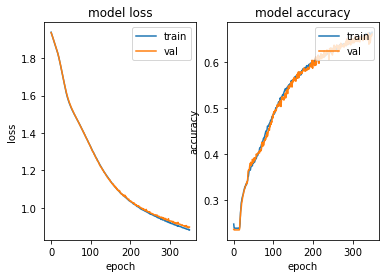

In [108]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper right')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('model accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper right')

plt.show()

In [109]:
score = model.evaluate(x=x_testcnn_scaled, y=y_test)
predictions = model.predict(x_testcnn_scaled)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

535/535 [==============================] - 0s 65us/step
Test loss: 0.9200951375693919
Test accuracy: 0.6560747623443604


In [110]:
print(classification_report(classes[np.argmax(y_test, axis=1)], classes[np.argmax(predictions, axis=1)]))

              precision    recall  f1-score   support

           A       0.91      0.68      0.78       127
           E       0.59      0.58      0.58        81
           F       0.60      0.46      0.52        46
           L       0.67      0.64      0.65        69
           N       0.48      0.63      0.55        71
           T       0.69      0.95      0.80        62
           W       0.60      0.62      0.61        79

    accuracy                           0.66       535
   macro avg       0.65      0.65      0.64       535
weighted avg       0.68      0.66      0.66       535



Model is better with no scaling! Models with scaling don't converge even after >350 epochs.

### model 2

In [111]:
model = Sequential()

model.add(Conv1D(256, 5, padding='same',input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 5, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 5, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(32, 5, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(7))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 40, 256)           1536      
_________________________________________________________________
activation_21 (Activation)   (None, 40, 256)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 40, 128)           163968    
_________________________________________________________________
activation_22 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 5, 128)           

In [112]:
#history = model.fit(x_traincnn, y_train, batch_size=16, epochs=250, validation_data=(x_valcnn, y_val),
#                   callbacks=[checkpoint])
history = model.fit(x_traincnn, y_train, batch_size=512, epochs=200, validation_data=(x_valcnn, y_val))

Train on 5564 samples, validate on 1391 samples
Epoch 1/200
5564/5564 [==============================] - 1s 101us/step - loss: 2.4905 - accuracy: 0.1154 - val_loss: 2.1297 - val_accuracy: 0.1172
Epoch 2/200
5564/5564 [==============================] - 0s 27us/step - loss: 2.0450 - accuracy: 0.1763 - val_loss: 1.8948 - val_accuracy: 0.3436
Epoch 3/200
5564/5564 [==============================] - 0s 28us/step - loss: 1.8656 - accuracy: 0.3269 - val_loss: 1.7790 - val_accuracy: 0.3465
Epoch 4/200
5564/5564 [==============================] - 0s 28us/step - loss: 1.7727 - accuracy: 0.3460 - val_loss: 1.7127 - val_accuracy: 0.3523
Epoch 5/200
5564/5564 [==============================] - 0s 28us/step - loss: 1.7098 - accuracy: 0.3623 - val_loss: 1.6571 - val_accuracy: 0.3825
Epoch 6/200
5564/5564 [==============================] - 0s 28us/step - loss: 1.6598 - accuracy: 0.3817 - val_loss: 1.6066 - val_accuracy: 0.3968
Epoch 7/200
5564/5564 [==============================] - 0s 28us/step - los

5564/5564 [==============================] - 0s 28us/step - loss: 0.8911 - accuracy: 0.6571 - val_loss: 0.9058 - val_accuracy: 0.6542
Epoch 57/200
5564/5564 [==============================] - 0s 28us/step - loss: 0.8880 - accuracy: 0.6506 - val_loss: 0.9010 - val_accuracy: 0.6549
Epoch 58/200
5564/5564 [==============================] - 0s 29us/step - loss: 0.8771 - accuracy: 0.6627 - val_loss: 0.8986 - val_accuracy: 0.6535
Epoch 59/200
5564/5564 [==============================] - 0s 28us/step - loss: 0.8740 - accuracy: 0.6556 - val_loss: 0.8952 - val_accuracy: 0.6585
Epoch 60/200
5564/5564 [==============================] - 0s 28us/step - loss: 0.8725 - accuracy: 0.6650 - val_loss: 0.8922 - val_accuracy: 0.6585
Epoch 61/200
5564/5564 [==============================] - 0s 28us/step - loss: 0.8664 - accuracy: 0.6623 - val_loss: 0.8781 - val_accuracy: 0.6643
Epoch 62/200
5564/5564 [==============================] - 0s 28us/step - loss: 0.8578 - accuracy: 0.6639 - val_loss: 0.8772 - val_a

Epoch 112/200
5564/5564 [==============================] - 0s 27us/step - loss: 0.6773 - accuracy: 0.7394 - val_loss: 0.7069 - val_accuracy: 0.7254
Epoch 113/200
5564/5564 [==============================] - 0s 27us/step - loss: 0.6728 - accuracy: 0.7423 - val_loss: 0.7036 - val_accuracy: 0.7340
Epoch 114/200
5564/5564 [==============================] - 0s 27us/step - loss: 0.6712 - accuracy: 0.7423 - val_loss: 0.7002 - val_accuracy: 0.7326
Epoch 115/200
5564/5564 [==============================] - 0s 27us/step - loss: 0.6714 - accuracy: 0.7419 - val_loss: 0.6964 - val_accuracy: 0.7311
Epoch 116/200
5564/5564 [==============================] - 0s 27us/step - loss: 0.6683 - accuracy: 0.7410 - val_loss: 0.6989 - val_accuracy: 0.7283
Epoch 117/200
5564/5564 [==============================] - 0s 27us/step - loss: 0.6621 - accuracy: 0.7453 - val_loss: 0.6980 - val_accuracy: 0.7304
Epoch 118/200
5564/5564 [==============================] - 0s 27us/step - loss: 0.6646 - accuracy: 0.7394 - val_

5564/5564 [==============================] - 0s 27us/step - loss: 0.5490 - accuracy: 0.7944 - val_loss: 0.5943 - val_accuracy: 0.7815
Epoch 168/200
5564/5564 [==============================] - 0s 27us/step - loss: 0.5497 - accuracy: 0.7865 - val_loss: 0.5852 - val_accuracy: 0.7843
Epoch 169/200
5564/5564 [==============================] - 0s 27us/step - loss: 0.5476 - accuracy: 0.7858 - val_loss: 0.5813 - val_accuracy: 0.7865
Epoch 170/200
5564/5564 [==============================] - 0s 27us/step - loss: 0.5429 - accuracy: 0.7931 - val_loss: 0.5801 - val_accuracy: 0.7843
Epoch 171/200
5564/5564 [==============================] - 0s 27us/step - loss: 0.5426 - accuracy: 0.7901 - val_loss: 0.5791 - val_accuracy: 0.7786
Epoch 172/200
5564/5564 [==============================] - 0s 27us/step - loss: 0.5377 - accuracy: 0.7922 - val_loss: 0.5781 - val_accuracy: 0.7764
Epoch 173/200
5564/5564 [==============================] - 0s 27us/step - loss: 0.5394 - accuracy: 0.7948 - val_loss: 0.5785 -

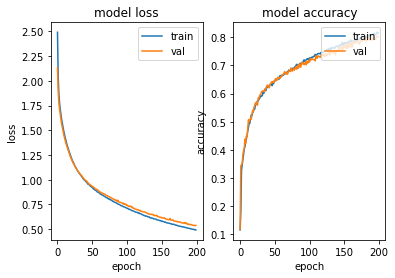

In [113]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper right')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('model accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper right')

plt.show()

In [114]:
score = model.evaluate(x=x_testcnn, y=y_test)
predictions = model.predict(x_testcnn)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

535/535 [==============================] - 0s 99us/step
Test loss: 0.5081647488558404
Test accuracy: 0.8355140089988708


In [115]:
print(classification_report(classes[np.argmax(y_test, axis=1)], classes[np.argmax(predictions, axis=1)]))

              precision    recall  f1-score   support

           A       0.96      0.84      0.90       127
           E       0.90      0.65      0.76        81
           F       0.78      0.93      0.85        46
           L       0.83      0.87      0.85        69
           N       0.77      0.75      0.76        71
           T       0.82      1.00      0.90        62
           W       0.75      0.87      0.81        79

    accuracy                           0.84       535
   macro avg       0.83      0.85      0.83       535
weighted avg       0.84      0.84      0.83       535



### save model

In [ ]:
model_name = 'cnn_model_2.h5'
save_dir = os.path.join(os.getcwd(), 'models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print(f'Saved model at {model_path}')


### simple one-layer NN

In [116]:
model = Sequential()
model.add(Flatten(input_shape=(40,1)))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 287       
Total params: 287
Trainable params: 287
Non-trainable params: 0
_________________________________________________________________


In [117]:
history = model.fit(x_traincnn, y_train, batch_size=512, epochs=200, validation_data=(x_valcnn, y_val))

Train on 5564 samples, validate on 1391 samples
Epoch 1/200
5564/5564 [==============================] - 0s 21us/step - loss: 41.4142 - accuracy: 0.0945 - val_loss: 39.4339 - val_accuracy: 0.0971
Epoch 2/200
5564/5564 [==============================] - 0s 5us/step - loss: 36.5222 - accuracy: 0.1005 - val_loss: 34.9871 - val_accuracy: 0.1057
Epoch 3/200
5564/5564 [==============================] - 0s 5us/step - loss: 32.4792 - accuracy: 0.1075 - val_loss: 31.3576 - val_accuracy: 0.1272
Epoch 4/200
5564/5564 [==============================] - 0s 5us/step - loss: 28.8408 - accuracy: 0.1170 - val_loss: 27.5182 - val_accuracy: 0.1438
Epoch 5/200
5564/5564 [==============================] - 0s 5us/step - loss: 25.1255 - accuracy: 0.1307 - val_loss: 23.6613 - val_accuracy: 0.1538
Epoch 6/200
5564/5564 [==============================] - 0s 5us/step - loss: 21.4846 - accuracy: 0.1384 - val_loss: 19.8258 - val_accuracy: 0.1632
Epoch 7/200
5564/5564 [==============================] - 0s 5us/step 

Epoch 57/200
5564/5564 [==============================] - 0s 5us/step - loss: 1.4478 - accuracy: 0.5953 - val_loss: 1.5438 - val_accuracy: 0.5687
Epoch 58/200
5564/5564 [==============================] - 0s 5us/step - loss: 1.4232 - accuracy: 0.6017 - val_loss: 1.5117 - val_accuracy: 0.5730
Epoch 59/200
5564/5564 [==============================] - 0s 5us/step - loss: 1.3968 - accuracy: 0.6044 - val_loss: 1.4829 - val_accuracy: 0.5809
Epoch 60/200
5564/5564 [==============================] - 0s 5us/step - loss: 1.3707 - accuracy: 0.6066 - val_loss: 1.4602 - val_accuracy: 0.5845
Epoch 61/200
5564/5564 [==============================] - 0s 5us/step - loss: 1.3512 - accuracy: 0.6086 - val_loss: 1.4350 - val_accuracy: 0.5830
Epoch 62/200
5564/5564 [==============================] - 0s 5us/step - loss: 1.3264 - accuracy: 0.6130 - val_loss: 1.4098 - val_accuracy: 0.5881
Epoch 63/200
5564/5564 [==============================] - 0s 5us/step - loss: 1.3065 - accuracy: 0.6188 - val_loss: 1.3934 -

5564/5564 [==============================] - 0s 5us/step - loss: 0.8226 - accuracy: 0.6914 - val_loss: 0.9002 - val_accuracy: 0.6513
Epoch 114/200
5564/5564 [==============================] - 0s 5us/step - loss: 0.8158 - accuracy: 0.6891 - val_loss: 0.8937 - val_accuracy: 0.6700
Epoch 115/200
5564/5564 [==============================] - 0s 5us/step - loss: 0.8117 - accuracy: 0.6921 - val_loss: 0.8930 - val_accuracy: 0.6592
Epoch 116/200
5564/5564 [==============================] - 0s 5us/step - loss: 0.8108 - accuracy: 0.6939 - val_loss: 0.8989 - val_accuracy: 0.6520
Epoch 117/200
5564/5564 [==============================] - 0s 5us/step - loss: 0.8055 - accuracy: 0.6939 - val_loss: 0.8802 - val_accuracy: 0.6707
Epoch 118/200
5564/5564 [==============================] - 0s 5us/step - loss: 0.8014 - accuracy: 0.6914 - val_loss: 0.8803 - val_accuracy: 0.6607
Epoch 119/200
5564/5564 [==============================] - 0s 5us/step - loss: 0.7966 - accuracy: 0.6936 - val_loss: 0.8771 - val_ac

Epoch 169/200
5564/5564 [==============================] - 0s 5us/step - loss: 0.7088 - accuracy: 0.7090 - val_loss: 0.7879 - val_accuracy: 0.6743
Epoch 170/200
5564/5564 [==============================] - 0s 5us/step - loss: 0.7067 - accuracy: 0.7132 - val_loss: 0.7772 - val_accuracy: 0.6794
Epoch 171/200
5564/5564 [==============================] - 0s 5us/step - loss: 0.7068 - accuracy: 0.7097 - val_loss: 0.7802 - val_accuracy: 0.6894
Epoch 172/200
5564/5564 [==============================] - 0s 5us/step - loss: 0.7049 - accuracy: 0.7060 - val_loss: 0.7831 - val_accuracy: 0.6830
Epoch 173/200
5564/5564 [==============================] - 0s 5us/step - loss: 0.7062 - accuracy: 0.7135 - val_loss: 0.7874 - val_accuracy: 0.6671
Epoch 174/200
5564/5564 [==============================] - 0s 5us/step - loss: 0.7043 - accuracy: 0.7114 - val_loss: 0.7741 - val_accuracy: 0.6930
Epoch 175/200
5564/5564 [==============================] - 0s 5us/step - loss: 0.7031 - accuracy: 0.7139 - val_loss: 0

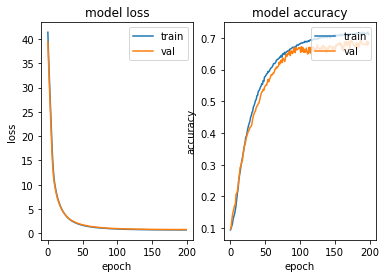

In [118]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper right')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('model accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper right')

plt.show()

In [119]:
score = model.evaluate(x=x_testcnn, y=y_test)
predictions = model.predict(x_testcnn)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

535/535 [==============================] - 0s 42us/step
Test loss: 0.6090983534527716
Test accuracy: 0.745794415473938


In [120]:
print(classification_report(classes[np.argmax(y_test, axis=1)], classes[np.argmax(predictions, axis=1)]))

              precision    recall  f1-score   support

           A       0.89      0.88      0.89       127
           E       0.72      0.48      0.58        81
           F       0.77      0.74      0.76        46
           L       0.64      0.75      0.69        69
           N       0.74      0.61      0.67        71
           T       0.73      0.98      0.84        62
           W       0.65      0.73      0.69        79

    accuracy                           0.75       535
   macro avg       0.74      0.74      0.73       535
weighted avg       0.75      0.75      0.74       535



### CNN -Conv2D

Here we compute the mfccs and retain the 2D format (instead of taking the mean of each mffc feature).

In [121]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=4, sharex=False,
                             sharey=True, figsize=(20,5))
    axes = axes.ravel()
    fig.suptitle('Time Series', size=16)
    
    for i in range(len(signals)):
        axes[i].set_title(list(signals.keys())[i])
        axes[i].plot(list(signals.values())[i])
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
    fig.delaxes(axes[-1])

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=4, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    axes = axes.ravel()
    
    for i in range(len(fft)):
        data = list(fft.values())[i]
        Y, freq = data[0], data[1]
        axes[i].set_title(list(fft.keys())[i])
        axes[i].plot(freq, Y)
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
    fig.delaxes(axes[-1])
    
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=4, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    axes = axes.ravel()
    
    for i in range(len(fbank)):
        axes[i].set_title(list(fbank.keys())[i])
        axes[i].imshow(list(fbank.values())[i],
                        cmap='hot', interpolation='nearest')
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
    fig.delaxes(axes[-1])
    
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=4, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    axes = axes.ravel()
    
    for i in range(len(mfccs)):
        axes[i].set_title(list(mfccs.keys())[i])
        axes[i].imshow(list(mfccs.values())[i],
                cmap='hot', interpolation='nearest')
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
    fig.delaxes(axes[-1])


In [122]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

In [123]:
df = df.drop('filename', axis=1)
df.reset_index(inplace=True)

In [124]:
df.set_index(df.filename, inplace=True)
for file in df.index:
    rate, signal = wavfile.read(f'{path}/{file}')
    df.at[file, 'length'] = signal.shape[0] / rate

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  This is separate from the ipykernel package so we can avoid doing imports until


In [125]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    wav_file = df[df.emotion == c]['filename'].iloc[0]
    signal, rate = librosa.load(f'{path}/{wav_file}', sr=16000)
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    # only take one second of signal
    # 16000/40=400 : since we take 25ms windows, 1s/40=0.025s
    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=400).T
    fbank[c] = bank
    
    # numcep: nb of cepstrals we keep after DCT => throw away 50%
    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=400).T
    mfccs[c] = mel

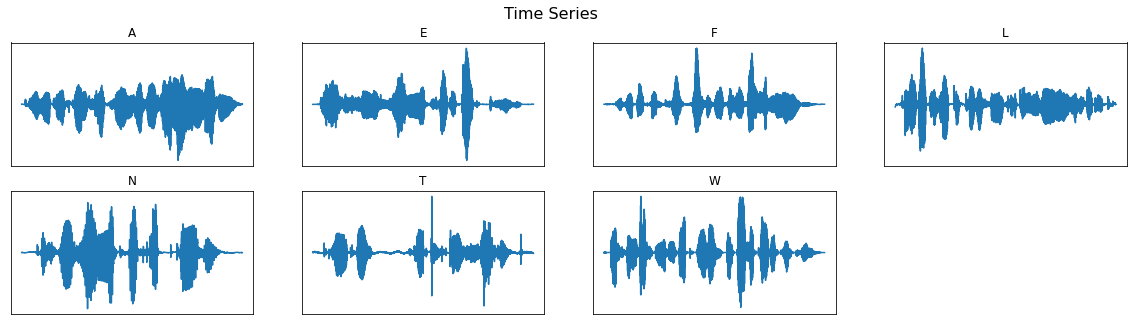

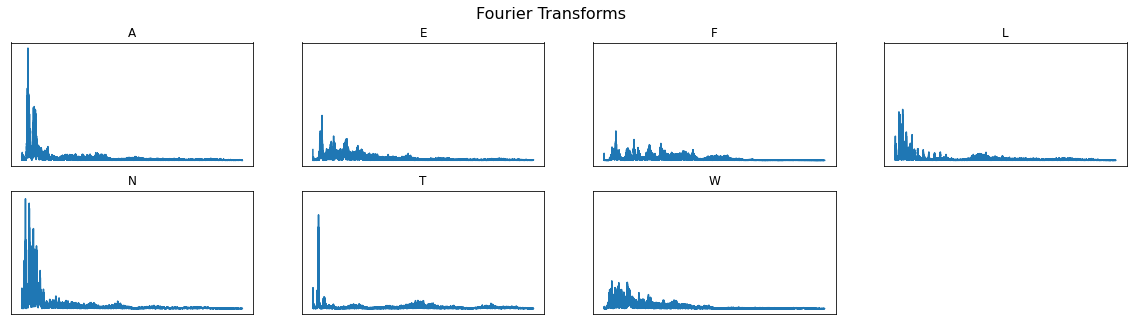

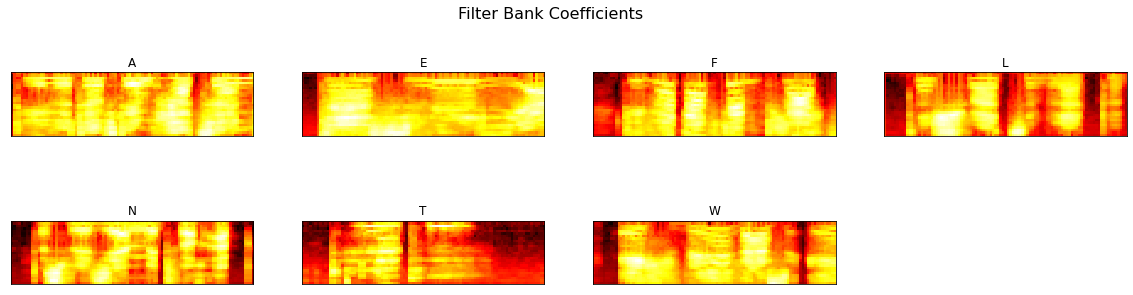

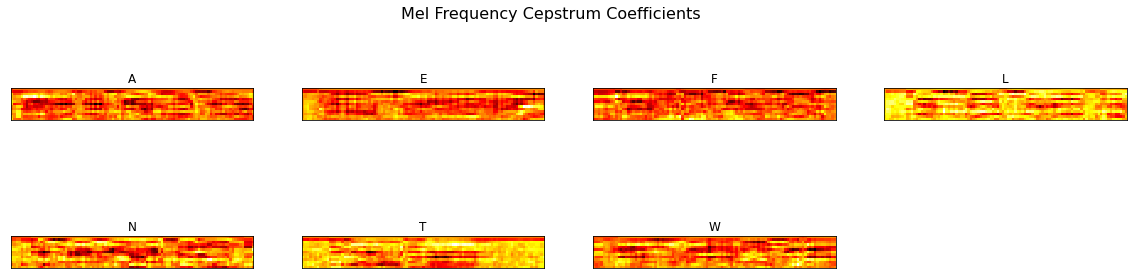

In [126]:
plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

With this approach, we do the same as before (compute the mfccs) but we plot the FFTs, Filterbank energies and DCTs.

- Can do noise threshold detection (Filtering): remove parts of audio with no sound => to keep only characteristic signal of each class
- FFT: can distinguish differences but not optimal
- Filterbank energies: patterns emerge (temporal relationships)
- DCT: plots are a lot more unique

### Modelling

Randomly sample 1s chunks out of audio => don't take entire signal sequence

In [127]:
n_samples = 2 * int(df['length'].sum() / 0.1)
n_samples

29740

In [128]:
df.set_index('filename', inplace=True)

In [152]:
def build_rand_feat():
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(emotion_count_by_class_pct.index, p=emotion_count_by_class_pct)
        file = np.random.choice(df[df.emotion == rand_class].index)
        rate, wav = wavfile.read(f'../data/wav/{file}')
        label = df.at[file, 'emotion']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample)
        y.append((np.where(classes == label))[0][0])
        
    config.min = _min
    config.max = _max
    
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
        
    y = to_categorical(y, num_classes=7)
    config.data = (X, y)
    
    with open(config.p_path, 'wb') as handle:
        # for compatibility with python 2: protocol=2
        pickle.dump(config, handle, protocol=2)
        
    return X, y

In [147]:
def check_data():
    if os.path.isfile(config.p_path):
        print(f'Loading existing data for {config.mode} model')
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None
        

In [148]:
# only pool down once because X is not high dimensional
# should try with batch norm
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
    

In [149]:
def get_recurrent_model():
    # shape of input X for RNN: (n, time, feat)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [182]:
config = Config(mode='conv')

In [191]:
np.random.seed(42)

if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()
elif config.mode == 'lstm':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()

Loading existing data for lstm model
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 9, 128)            72704     
_________________________________________________________________
lstm_6 (LSTM)                (None, 9, 128)            131584    
_________________________________________________________________
dropout_16 (Dropout)         (None, 9, 128)            0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 9, 64)             8256      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 9, 32)             2080      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 9, 16)             528       
_________________________________________________________________
time_distributed

### train/test/val

This approach will not include data augmentation due to lack of time for implementing it. Instead, 1s samples are sampled at random through all the raw data to build the sets.

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=43)

In [193]:
print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(42825, 9, 13) (5948, 9, 13) (10707, 9, 13)
(42825, 7) (5948, 7) (10707, 7)


### Create class weights

Weight matrix update will put more emphasis on gradient steps for under-represented classes

In [156]:
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)
class_weight

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1 2 3 4 5 6], y=[3 1 3 ... 0 0 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


array([1.0791393 , 1.65636313, 1.0916165 , 0.93953371, 0.97310385,
       1.22296241, 0.60832924])

### Train

In [ ]:
checkpoint = ModelCheckpoint('../models/run1/model.{epoch:02d}-{accuracy:.4f}-{val_accuracy:.4f}-{loss:.4f}-{val_loss:.4f}.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True,
                            save_weights_only=False, period=1)

In [186]:
#history = model.fit(X_train, y_train, epochs=250, batch_size=512, shuffle=True, validation_data=(X_val, y_val), 
#         callbacks=[checkpoint], class_weight=class_weight)

history = model.fit(X_train, y_train, epochs=60, batch_size=512, shuffle=True, validation_data=(X_val, y_val),
                   class_weight=class_weight)

Train on 21412 samples, validate on 5354 samples
Epoch 1/60
21412/21412 [==============================] - 1s 44us/step - loss: 1.8760 - accuracy: 0.2408 - val_loss: 1.8047 - val_accuracy: 0.2682
Epoch 2/60
21412/21412 [==============================] - 1s 24us/step - loss: 1.7063 - accuracy: 0.3237 - val_loss: 1.6560 - val_accuracy: 0.3496
Epoch 3/60
21412/21412 [==============================] - 1s 24us/step - loss: 1.6068 - accuracy: 0.3721 - val_loss: 1.5780 - val_accuracy: 0.3904
Epoch 4/60
21412/21412 [==============================] - 1s 24us/step - loss: 1.5636 - accuracy: 0.3874 - val_loss: 1.5764 - val_accuracy: 0.3928
Epoch 5/60
21412/21412 [==============================] - 1s 24us/step - loss: 1.5203 - accuracy: 0.4031 - val_loss: 1.5096 - val_accuracy: 0.4227
Epoch 6/60
21412/21412 [==============================] - 1s 24us/step - loss: 1.4955 - accuracy: 0.4172 - val_loss: 1.4701 - val_accuracy: 0.4296
Epoch 7/60
21412/21412 [==============================] - 1s 24us/ste

21412/21412 [==============================] - 1s 24us/step - loss: 0.6116 - accuracy: 0.7741 - val_loss: 1.0660 - val_accuracy: 0.6298
Epoch 57/60
21412/21412 [==============================] - 1s 24us/step - loss: 0.5933 - accuracy: 0.7803 - val_loss: 1.0641 - val_accuracy: 0.6311
Epoch 58/60
21412/21412 [==============================] - 1s 24us/step - loss: 0.5760 - accuracy: 0.7879 - val_loss: 1.0719 - val_accuracy: 0.6337
Epoch 59/60
21412/21412 [==============================] - 1s 24us/step - loss: 0.5855 - accuracy: 0.7860 - val_loss: 1.1115 - val_accuracy: 0.6304
Epoch 60/60
21412/21412 [==============================] - 1s 24us/step - loss: 0.5801 - accuracy: 0.7874 - val_loss: 1.0928 - val_accuracy: 0.6352


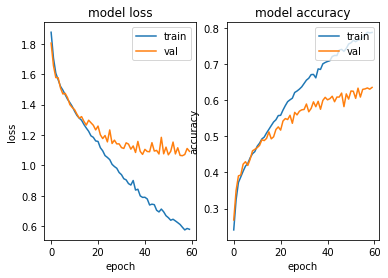

In [187]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper right')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('model accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper right')

plt.show()

In [188]:
score = model.evaluate(x=X_test, y=y_test)
predictions = model.predict(X_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

2974/2974 [==============================] - 0s 68us/step
Test loss: 1.0448104100653848
Test accuracy: 0.6573638319969177


In [189]:
print(classification_report(classes[np.argmax(y_test, axis=1)], classes[np.argmax(predictions, axis=1)]))

              precision    recall  f1-score   support

           A       0.60      0.56      0.58       389
           E       0.66      0.58      0.61       273
           F       0.59      0.53      0.56       378
           L       0.58      0.63      0.61       440
           N       0.61      0.66      0.63       410
           T       0.79      0.68      0.73       373
           W       0.73      0.81      0.77       711

    accuracy                           0.66      2974
   macro avg       0.65      0.64      0.64      2974
weighted avg       0.66      0.66      0.66      2974



### lstm

In [190]:
config = Config(mode='lstm')

In [194]:
history = model.fit(X_train, y_train, epochs=100, batch_size=512, validation_data=(X_val, y_val), class_weight=class_weight)

Train on 42825 samples, validate on 10707 samples
Epoch 1/100
42825/42825 [==============================] - 3s 80us/step - loss: 1.8873 - accuracy: 0.2358 - val_loss: 1.8328 - val_accuracy: 0.2650
Epoch 2/100
42825/42825 [==============================] - 3s 61us/step - loss: 1.7721 - accuracy: 0.2878 - val_loss: 1.7261 - val_accuracy: 0.3179
Epoch 3/100
42825/42825 [==============================] - 3s 64us/step - loss: 1.6884 - accuracy: 0.3316 - val_loss: 1.6572 - val_accuracy: 0.3395
Epoch 4/100
42825/42825 [==============================] - 3s 64us/step - loss: 1.6409 - accuracy: 0.3493 - val_loss: 1.6207 - val_accuracy: 0.3555
Epoch 5/100
42825/42825 [==============================] - 3s 65us/step - loss: 1.6095 - accuracy: 0.3598 - val_loss: 1.5845 - val_accuracy: 0.3723
Epoch 6/100
42825/42825 [==============================] - 3s 61us/step - loss: 1.5970 - accuracy: 0.3667 - val_loss: 1.6339 - val_accuracy: 0.3484
Epoch 7/100
42825/42825 [==============================] - 2s 

Epoch 56/100
42825/42825 [==============================] - 2s 58us/step - loss: 1.0487 - accuracy: 0.5870 - val_loss: 1.1028 - val_accuracy: 0.5636
Epoch 57/100
42825/42825 [==============================] - 2s 57us/step - loss: 1.0750 - accuracy: 0.5740 - val_loss: 1.1333 - val_accuracy: 0.5538
Epoch 58/100
42825/42825 [==============================] - 2s 58us/step - loss: 1.0560 - accuracy: 0.5834 - val_loss: 1.0818 - val_accuracy: 0.5758
Epoch 59/100
42825/42825 [==============================] - 2s 58us/step - loss: 1.0299 - accuracy: 0.5936 - val_loss: 1.0614 - val_accuracy: 0.5769
Epoch 60/100
42825/42825 [==============================] - 2s 58us/step - loss: 1.0293 - accuracy: 0.5951 - val_loss: 1.0468 - val_accuracy: 0.5837
Epoch 61/100
42825/42825 [==============================] - 2s 58us/step - loss: 1.0159 - accuracy: 0.5998 - val_loss: 1.3217 - val_accuracy: 0.5067
Epoch 62/100
42825/42825 [==============================] - 2s 58us/step - loss: 1.0319 - accuracy: 0.5943

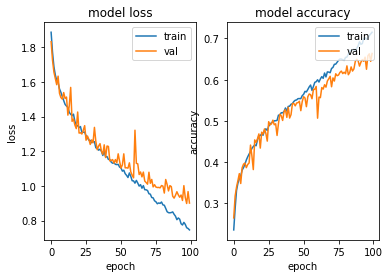

In [195]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper right')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('model accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper right')

plt.show()

In [196]:
score = model.evaluate(x=X_test, y=y_test)
predictions = model.predict(X_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

5948/5948 [==============================] - 1s 133us/step
Test loss: 0.8837402156718882
Test accuracy: 0.6753530502319336


In [197]:
print(classification_report(classes[np.argmax(y_test, axis=1)], classes[np.argmax(predictions, axis=1)]))

              precision    recall  f1-score   support

           A       0.60      0.72      0.66       762
           E       0.69      0.55      0.61       516
           F       0.69      0.58      0.63       837
           L       0.63      0.50      0.56       910
           N       0.58      0.70      0.63       887
           T       0.72      0.69      0.70       659
           W       0.78      0.85      0.82      1377

    accuracy                           0.68      5948
   macro avg       0.67      0.66      0.66      5948
weighted avg       0.68      0.68      0.67      5948



Need a lot more epochs for training to converge.

### Autoencoder

I tried to encode the mfccs to a lower dimensionality with the idea of training the models with the encoded representation, but this approach was not very successful. Indeed, the mfccs are already pretty low dimensional so it may be a waste of time. The end goal was to have a VAE to generate new samples to enrich the training data, but I did not have the time to implement this. Below you can find different autoencoder implementations.

In [198]:
# this is the size of our encoded representations
encoding_dim = 60  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_data = Input(shape=(117,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_data)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(117, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)
opt = Adadelta(learning_rate=0.1)
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 117)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 60)                7080      
_________________________________________________________________
dense_47 (Dense)             (None, 117)               7137      
Total params: 14,217
Trainable params: 14,217
Non-trainable params: 0
_________________________________________________________________


In [199]:
# this model maps an input to its encoded representation
encoder = Model(input_data, encoded)

In [200]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [201]:
history = autoencoder.fit(X_train.reshape(X_train.shape[0], -1), X_train.reshape(X_train.shape[0], -1),
                epochs=100,
                batch_size=512,
                validation_data=(X_val.reshape(X_val.shape[0], -1), X_val.reshape(X_val.shape[0], -1)))

Train on 42825 samples, validate on 10707 samples
Epoch 1/100
42825/42825 [==============================] - 0s 9us/step - loss: 0.6983 - val_loss: 0.6954
Epoch 2/100
42825/42825 [==============================] - 0s 5us/step - loss: 0.6944 - val_loss: 0.6937
Epoch 3/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6934 - val_loss: 0.6931
Epoch 4/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6930 - val_loss: 0.6928
Epoch 5/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6927 - val_loss: 0.6926
Epoch 6/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6926 - val_loss: 0.6925
Epoch 7/100
42825/42825 [==============================] - 0s 5us/step - loss: 0.6925 - val_loss: 0.6924
Epoch 8/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6924 - val_loss: 0.6923
Epoch 9/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6923 - val_loss: 0.6922
Epoch

Epoch 78/100
42825/42825 [==============================] - 0s 5us/step - loss: 0.6904 - val_loss: 0.6904
Epoch 79/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6904 - val_loss: 0.6904
Epoch 80/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6904 - val_loss: 0.6904
Epoch 81/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6904 - val_loss: 0.6904
Epoch 82/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6904 - val_loss: 0.6904
Epoch 83/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6904 - val_loss: 0.6903
Epoch 84/100
42825/42825 [==============================] - 0s 5us/step - loss: 0.6903 - val_loss: 0.6903
Epoch 85/100
42825/42825 [==============================] - 0s 5us/step - loss: 0.6903 - val_loss: 0.6903
Epoch 86/100
42825/42825 [==============================] - 0s 5us/step - loss: 0.6903 - val_loss: 0.6903
Epoch 87/100
42825/42825 [====================

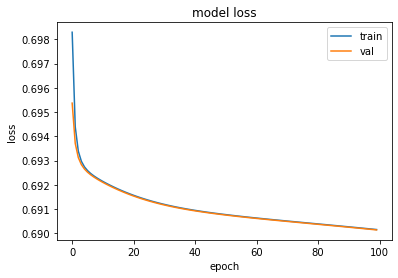

In [202]:
fig, ax1 = plt.subplots(1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper right')

plt.show()

In [203]:
encoded_data = encoder.predict(X_test.reshape(X_test.shape[0], -1))
decoded_data = decoder.predict(encoded_data)

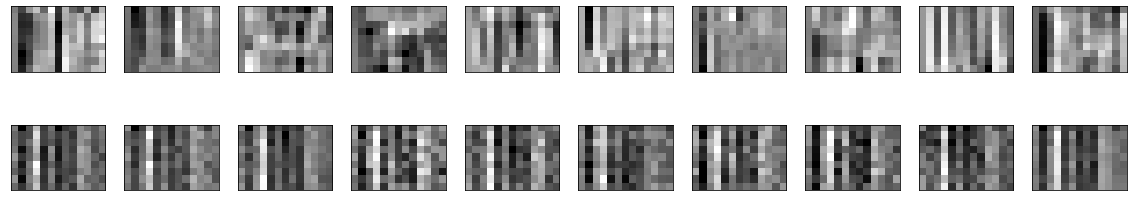

In [204]:
n = 10  # how many mfccs we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(9, 13))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_data[i].reshape(9, 13))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### sparse autoencoder

In [205]:
# this is the size of our encoded representations
encoding_dim = 60  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_data = Input(shape=(117,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu',
               activity_regularizer=regularizers.l1(10e-5))(input_data)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(117, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
sparse_autoencoder = Model(input_data, decoded)

sparse_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
sparse_autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 117)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 60)                7080      
_________________________________________________________________
dense_49 (Dense)             (None, 117)               7137      
Total params: 14,217
Trainable params: 14,217
Non-trainable params: 0
_________________________________________________________________


In [206]:
# this model maps an input to its encoded representation
encoder = Model(input_data, encoded)

In [207]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [208]:
history = sparse_autoencoder.fit(X_train.reshape(X_train.shape[0], -1), X_train.reshape(X_train.shape[0], -1),
                epochs=100,
                batch_size=512,
                validation_data=(X_val.reshape(X_val.shape[0], -1), X_val.reshape(X_val.shape[0], -1)))

Train on 42825 samples, validate on 10707 samples
Epoch 1/100
42825/42825 [==============================] - 0s 8us/step - loss: 0.7289 - val_loss: 0.6927
Epoch 2/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6924 - val_loss: 0.6922
Epoch 3/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6920 - val_loss: 0.6918
Epoch 4/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6917 - val_loss: 0.6916
Epoch 5/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6915 - val_loss: 0.6915
Epoch 6/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6914 - val_loss: 0.6914
Epoch 7/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6913 - val_loss: 0.6913
Epoch 8/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6913 - val_loss: 0.6912
Epoch 9/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6912 - val_loss: 0.6912
Epoch

Epoch 78/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6911 - val_loss: 0.6911
Epoch 79/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6911 - val_loss: 0.6911
Epoch 80/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6911 - val_loss: 0.6911
Epoch 81/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6911 - val_loss: 0.6911
Epoch 82/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6911 - val_loss: 0.6911
Epoch 83/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6911 - val_loss: 0.6911
Epoch 84/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6911 - val_loss: 0.6911
Epoch 85/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6911 - val_loss: 0.6911
Epoch 86/100
42825/42825 [==============================] - 0s 6us/step - loss: 0.6911 - val_loss: 0.6911
Epoch 87/100
42825/42825 [====================

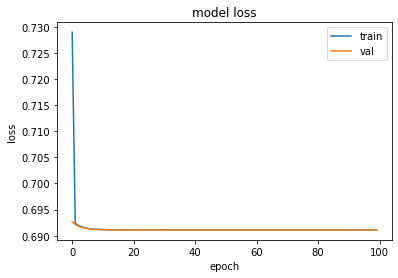

In [209]:
fig, ax1 = plt.subplots(1)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper right')

plt.show()

In [210]:
encoded_data = encoder.predict(X_test.reshape(X_test.shape[0], -1))
decoded_data = decoder.predict(encoded_data)

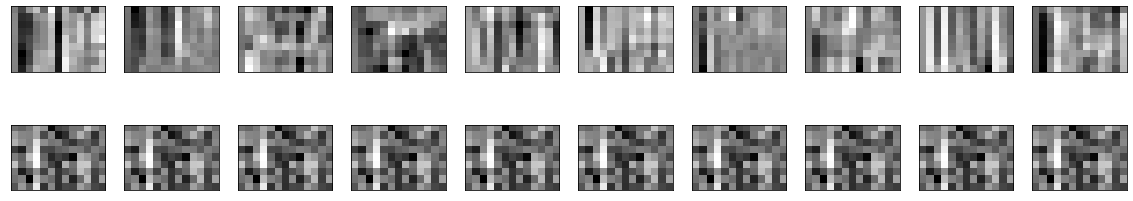

In [211]:
n = 10  # how many mfccs we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(9, 13))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_data[i].reshape(9, 13))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Summary of Results

In summary, the best model was surprisingly the kNN (even without any class balancing). The CNNs performed worse and at a greater computational cost (even with class balancing), so it was decided to focus on the simple kNN instead.  

Since the kNN model is fast to fit, I performed a grid search CV using a grid of possible hyperparameters. The best hyperparameters are determined by the CV test score (mean test accuracy across the folds).

The kNN achieves 96.9% CV test accuracy with:

- n_neighbors: 3
- weights: 'distance'
- algorithm: 'auto'
- leaf_size: '5'
- metric: 'euclidean'

and is implemented in the Flask app. Note that the current test CV displayed in the notebook is slightly lower, as the original run was not done with a fixed random seed. You can also note that the SVM model has slightly higher test accuracy during this final notebook run. This wasn't the case previously (kNN outperformed SVM) so the SVM wasn't considered to be the best model in the Flask implementation.